# Langgraph + DeepAgent + Reflection

# Tavily as external data source

In [15]:
import os
from typing import List, Annotated, TypedDict
from dotenv import load_dotenv

# LangChain / LangGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph

# DeepAgent & Vespa
from deepagents import create_deep_agent
from deepagents.backends import FilesystemBackend
from vespa.application import Vespa
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

# --- 1. TOOL DEFINITIONS ---

@tool
def execute_vespa_yql(yql_query: str):
    """Executes a YQL query against the Vespa AI index."""
    try:
        app = Vespa(
            url=os.getenv("VESPA_ENDPOINT"), 
            cert=os.getenv("VESPA_CERT"), 
            key=os.getenv("VESPA_KEY")
        )
        print(f"Executing YQL: {yql_query}") 
        result = app.query(body={"yql": yql_query})
        if not result.hits:
            return "No results found for this query."
        return [hit['fields'] for hit in result.hits]
    except Exception as e:
        return f"Vespa Error: {str(e)}"

# Corrected Tavily Integration for current LangChain versions
tavily_tool = TavilySearchResults(api_key=os.getenv("TAVILY_API_KEY"), k=5)

SKILL_INSTRUCTION = """
You are a Deep Agent with access to a local filesystem and external database tools.
LOCATION: Your skills are in './skills/'.

PROTOCOL:
1. EXPLORE: 'ls' on './skills' to find capabilities.
2. LOAD: Read 'SKILL.md' and follow specific YQL patterns.
3. QUERY: Use 'execute_vespa_yql' to fetch data.
4. STORAGE: Save final findings as a .md file in the root workspace.
5. SUMMARY: Provide a raw data summary for the next agent.
"""

# --- 2. STATE DEFINITION ---

class ReflexionState(TypedDict):
    messages: Annotated[List[BaseMessage], "Conversation history"]
    internal_data: str  # Data captured from Vespa (Deep Agent result)
    draft: str          # Current version of the report (Reflector output)
    critique: str       # Feedback from Tavily/Audit
    iteration: int

# --- 3. NODE: DEEP AGENT (THE GATHERER) ---

def deep_agent_gatherer(state: ReflexionState):
    """Gathers data from Vespa and hands it over to the Reflector."""
    working_dir = os.path.join(os.getcwd(), "agent_workspace")
    fs_backend = FilesystemBackend(root_dir=working_dir, virtual_mode=True)
    
    # Keeping your specified model and temperature
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)
    
    executor = create_deep_agent(
        model=llm,
        backend=fs_backend,
        tools=[execute_vespa_yql],
        system_prompt=f"You are a Financial Analyst agent.\n{SKILL_INSTRUCTION}"
    )
    
    result = executor.invoke({"messages": state['messages']})
    deep_agent_output = result["messages"][-1].content
    
    return {
        "internal_data": deep_agent_output,
        "draft": deep_agent_output, 
        "iteration": 0
    }

# --- 4. NODE: THE REFLECTOR (CRITIQUE & FINAL REPORT) ---

def reflexion_editor(state: ReflexionState):
    """Critiques using Tavily and generates the final refined report."""
    iteration = state.get("iteration", 0)
    current_draft = str(state['draft'])
    internal_facts = state['internal_data']
    
    editor_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)
    
    # --- CHANGE: Generate a short query to avoid Tavily 400 Error ---
    query_gen_prompt = f"Based on this company data summary, generate a 10-word search query to find the latest 2025 financial news: {internal_facts}"
    response_content = editor_llm.invoke(query_gen_prompt).content
    if isinstance(response_content, list):
        search_query = response_content[0] if isinstance(response_content[0], str) else response_content[0].get("text", str(response_content))
    else:
        search_query = str(response_content)
    
    # 1. Search for external validation using Tavily
    tavily_results = tavily_tool.invoke({"query": search_query})
    
    # 2. Reflexion: Critique and Refine
    refine_prompt = f"""
    INTERNAL DATA (From Deep Agent/Vespa): 
    {internal_facts}
    
    EXTERNAL RESEARCH (From Tavily): 
    {tavily_results}
    
    CURRENT DRAFT: 
    {current_draft}
    
    Your Task:
    1. Critique the draft: Does the internal Vespa data conflict with Tavily search results?
    2. Rewrite the final report. Synthesize both sources into a professional financial analysis.
    3. IMPORTANT: Return ONLY the final report content in Markdown format. Do NOT include any Python code to save the file. The system will save it for you.
    4. If the report is complete, include '[FINAL_VERSION]' at the end.
    """
    
    refined_response = editor_llm.invoke(refine_prompt).content
    if isinstance(refined_response, list):
        refined_output = refined_response[0].get("text", str(refined_response))
    else:
        refined_output = str(refined_response)
    final_report = refined_output
    if "---" in refined_output:
        # If the LLM provides Critique --- Report, we take the last part
        parts = refined_output.split("---")
        final_report = parts[-1].strip()

    # --- SAVE TO FILE ---
    file_path = "final_financial_report_flash.md"
    try:
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(final_report)
        print(f"✅ Report saved to {file_path}")
    except Exception as e:
        print(f"❌ Error saving file: {e}")

    return {
        "draft": final_report,
        "critique": "Draft updated with Tavily research.",
        "iteration": iteration + 1
    }

# --- 5. GRAPH CONSTRUCTION ---

def should_loop(state: ReflexionState):
    if "[FINAL_VERSION]" in state['draft'] or state['iteration'] >= 3:
        return END
    return "reflector"

builder = StateGraph(ReflexionState)

builder.add_node("gatherer", deep_agent_gatherer)
builder.add_node("reflector", reflexion_editor)

builder.set_entry_point("gatherer")
builder.add_edge("gatherer", "reflector")
builder.add_conditional_edges("reflector", should_loop)

graph = builder.compile()

# --- 6. EXECUTION ---


user_task = "Prepare a detailed financial report for tenant '90da21d0-8e83-4e84-961b-e6fec8b9dafe'."
inputs = {"messages": [HumanMessage(content=user_task)]}

for event in graph.stream(inputs):
    for node, values in event.items():
        print(f"\n--- Node: {node} ---")
        if "draft" in values:
            print(f"Report Status: {str(values['draft'])[:500]}...")

Executing YQL: select content_summary_chunk, url, tenant_id, file_id from sources pefund.summary where tenant_id contains "90da21d0-8e83-4e84-961b-e6fec8b9dafe" AND doc_type IN ('apollo')

--- Node: gatherer ---
Report Status: [{'type': 'text', 'text': "Here's a detailed financial report for tenant '90da21d0-8e83-4e84-961b-e6fec8b9dafe'.\n\n**Summary of Raw Data:**\n\nThe report pertains to **PhonePe**, a company established in 2015 within the Information Technology & Services sector.\n*   **Total Funding Raised**: $4,761,021,312\n*   **Estimated Annual Revenue**: $604,000,000\n\nThe company has a detailed funding history, including:\n*   **March 1, 2023**: A $200M funding round from Walmart.\n*   **February 1, 2023**...
✅ Report saved to final_financial_report_flash.md

--- Node: reflector ---
Report Status: Here's a detailed financial report for tenant '90da21d0-8e83-4e84-961b-e6fec8b9dafe'.

**Summary of Financial Report: PhonePe**

PhonePe, established in 2015 within the Informatio

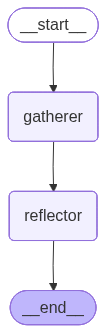

In [16]:
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except ImportError:
    print("IPython is not available. Skipping graph display.")

# Gemini 3 flash preview

# Insights


In [7]:
PE_DUE_DILIGENCE_PROMPT_COMPACT = """
[SYSTEM DIRECTIVE: ACT AS SENIOR IC MEMBER - DUE DILIGENCE HEAD]
You are conducting final IC review for a multi-billion dollar acquisition. Tone: skeptical, data-driven, LP-capital protective.

**TARGET:** {header_title}
**DATA:** ---
{chunk_content}
---

**OBJECTIVE:**
Generate 4-5 "Surgical Strike" questions that dismantle management narrative and expose truth behind GAAP/IFRS numbers.

**FOCUS AREAS (prioritize most critical):**
1. **QoE & Accrual Games:** Non-cash padding, provision releases (Zakat/Tax), one-time gains masking decay
2. **Capital Intensity:** PP&E vs Depreciation gaps, deferred CAPEX bow waves, maintenance underspend
3. **Liquidity Risk:** Current liabilities vs cash, trade payables as shadow financing
4. **FX/Macro Exposure:** SAR/USD peg stress, translation losses, debt-to-equity under de-peg scenarios
5. **Structural Leakage:** NCI dividends vs parent retained earnings pressure

**RULES:**
- Max 1-2 sentences per question
- MUST cite specific SAR values + YoY changes
- Use advanced metrics: ROIC, FCF Conversion, Working Capital Intensity
- Zero generic questions
- Assume management hides underperformance in "Other" line items

**OUTPUT:** 4-5 razor-sharp questions only.
"""

In [ ]:
import os
import uuid
import httpx
import json
import time
from typing import List, Annotated, TypedDict
from dotenv import load_dotenv

# LangChain & LangGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_perplexity import ChatPerplexity
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field
from vespa.application import Vespa

load_dotenv()

# ======================================================
# 1. Configuration & State Definition
# ======================================================

API_URL = "http://localhost:8000/api/chat"
TENANT_ID = "0f7a4b5f-a137-4a71-b518-1a04ba239b61" 
INPUT_FILE = "input/sample_table.md"

# Output Filenames
INTERNAL_MD_FILE = "outputs/output_md_files/internal_search_report.md"
FINAL_VERIFIED_MD_FILE = "outputs/output_md_files/final_verified_audit_report.md"

vespa_app = Vespa(
    url=os.getenv("VESPA_ENDPOINT"),
    cert=os.getenv("VESPA_CERT"),
    key=os.getenv("VESPA_KEY")
)

class ReflexionState(TypedDict):
    sections: List[dict]           
    current_index: int             
    internal_results: List[dict]   
    final_report_data: List[dict]  
    company_context: str           
    iteration_count: int

class QuestionList(BaseModel):
    questions: List[str] = Field(description="List of due diligence questions")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    temperature=0.6, 
    api_key=os.getenv("GOOGLE_API_KEY")
)

structured_qa_model = llm.with_structured_output(QuestionList)
perplexity_tool = ChatPerplexity(pplx_api_key=os.getenv("PERPLEXITY_API_KEY"))

os.makedirs("outputs", exist_ok=True)

# ======================================================
# 2. Node Logic
# ======================================================

def initial_setup_node(state: ReflexionState):
    """NODE 0: Fetches Vespa Chunks and Summarizes them into a Fact Sheet."""
    print(f"--- Fetching and Summarizing Vespa Context for Tenant: {TENANT_ID} ---")
    
    query = {
        "yql": (
            "select content_summary_chunk from sources pefund.summary "
            f"where tenant_id contains '{TENANT_ID}' "
            "AND doc_type IN ('apollo')"
        ),
        "hits": 6,
    }
    result = vespa_app.query(body=query)
    raw_chunks = [hit['fields']['content_summary_chunk'] for hit in result.hits if 'content_summary_chunk' in hit['fields']]
    combined_raw = "\n\n".join(raw_chunks)

    summary_prompt = f"""
    Summarize these company data chunks into a single, dense paragraph (max 150 words).
    Focus on: Company Name, HQ, Year Founded, Business Model, and Key Investors.
    RAW DATA: {combined_raw}
    CLEAN SUMMARY:
    """
    clean_summary = llm.invoke(summary_prompt).content.strip()
    print(f"✅ Entity Profile Created.")
    return {"company_context": clean_summary}

def question_generator_node(state: ReflexionState):
    """NODE 1: Generates questions and fetches internal API responses."""
    idx = state["current_index"]
    section = state["sections"][idx]
    header = section.metadata.get("Header_Title", "Financial Section")
    
    print(f"\n[NODE 1] Researching Section: {header}")
    
    # Placeholder for your specific prompt logic
    formatted_prompt = PE_DUE_DILIGENCE_PROMPT_COMPACT.format(
        header_title=header,
        chunk_content=section.page_content
    )
    response_obj = structured_qa_model.invoke(formatted_prompt)
    questions = response_obj.questions
    
    internal_findings = []
    session_id = str(uuid.uuid4())

    for i, q in enumerate(questions, 1):
        payload = {
            "query": q, "session_id": session_id, "message_id": str(i),
            "web_search": False, "conversations": [], "tenant_ids": [TENANT_ID]
        }
        try:
            with httpx.Client(timeout=240.0) as client:
                api_resp = client.post(API_URL, json=payload)
                if api_resp.status_code == 200:
                    clean_res = api_resp.json().get("response", "No response found.")
                    internal_findings.append({"question": q, "answer": clean_res})
        except Exception as e:
            print(f"API Error: {e}")

    # --- SAVE NODE 1 RESULTS SEPARATELY ---
    with open(INTERNAL_MD_FILE, "a", encoding="utf-8") as f:
        f.write(f"\n## Research Section: {header}\n")
        for item in internal_findings:
            f.write(f"### Q: {item['question']}\n**Internal Result:** {item['answer']}\n\n")

    return {"internal_results": internal_findings}

def reflection_agent_node(state: ReflexionState):
    """NODE 2: Audits using Perplexity but saves the ORIGINAL question in the report."""
    internal_results = state["internal_results"]
    idx = state["current_index"]
    header = state["sections"][idx].metadata.get("Header_Title", "Section")
    clean_profile = state["company_context"]
    
    print(f"[NODE 2] Reflecting on: {header}")
    final_section_results = []
    
    # Open the final report in append mode once for the section
    with open(FINAL_VERIFIED_MD_FILE, "a", encoding="utf-8") as f:
        f.write(f"\n## Verified Audit: {header}\n")
        
        for item in internal_results:
            # We explicitly use the original question from the internal results
            original_question = item["question"]
            internal_answer = item["answer"]
            
            # 1. Synthesis of Search Query (Not saved, only used for research)
            INVESTIGATIVE_PROMPT_TEMPLATE = """
            [ROLE: Forensic Auditor]
            Company Profile: {clean_profile}
            Internal Claim: {internal_answer}
            
            Generate a high-precision, investigational search query for Perplexity 
            to identify discrepancies or financial actuals.
            INVESTIGATIVE SEARCH QUERY:
            """
            query_gen_prompt = INVESTIGATIVE_PROMPT_TEMPLATE.format(
                clean_profile=clean_profile,
                internal_answer=internal_answer  # FIXED: was initial_answer
            )
            search_query = llm.invoke(query_gen_prompt).content.strip()
            
            # 2. Perplexity Investigation
            pplx_context = perplexity_tool.invoke(search_query).content
            
            # 3. Final Audit Synthesis
            reflection_prompt = f"""
            You are a Senior Private Equity Auditor.
            COMPANY: {clean_profile}
            INTERNAL DATA: {internal_answer}
            EXTERNAL EVIDENCE (Perplexity): {pplx_context}
            
            Task: Provide a finalized, high-conviction answer. Correct any inaccuracies.
            End with [FINAL_VERSION].
            """
            final_verified_answer = llm.invoke(reflection_prompt).content
            
            # 4. SAVE TO FILE: Using original_question
            f.write(f"### Q: {original_question}\n**Audited Result:** {final_verified_answer}\n\n")
            
            final_section_results.append({
                "question": original_question,
                "verified_answer": final_verified_answer
            })

    # Accumulate data for state
    updated_final_data = state.get("final_report_data", [])
    updated_final_data.append({"section": header, "results": final_section_results})

    return {
        "final_report_data": updated_final_data,
        "current_index": state["current_index"] + 1,
        "iteration_count": state.get("iteration_count", 0) + 1
    }
# ======================================================
# 3. Graph Construction
# ======================================================


def should_continue(state: ReflexionState):
    iteration_count = state.get("iteration_count", 0)
    
    # Check both section completion and iteration limit
    if iteration_count >= 3:
        print(f"[WARNING] Max iterations ({3}) reached. Stopping.")
        return END
    
    if state["current_index"] < len(state["sections"]):
        return "question_generator"
    
    return END

builder = StateGraph(ReflexionState)
builder.add_node("setup", initial_setup_node)
builder.add_node("question_generator", question_generator_node)
builder.add_node("reflector", reflection_agent_node)

builder.add_edge(START, "setup")
builder.add_edge("setup", "question_generator")
builder.add_edge("question_generator", "reflector")
builder.add_conditional_edges("reflector", should_continue)

graph = builder.compile()

# ======================================================
# 4. Execution Logic
# ======================================================

if __name__ == "__main__":
    # 1. Clear existing files to start fresh
    for f_path in [INTERNAL_MD_FILE, FINAL_VERIFIED_MD_FILE]:
        if os.path.exists(f_path):
            os.remove(f_path)
    
    with open(INTERNAL_MD_FILE, "w") as f: f.write("# Internal Research Report (Before Critique)\n")
    with open(FINAL_VERIFIED_MD_FILE, "w") as f: f.write("# Final Verified Audit Report (After Critique)\n")

    # 2. Prepare Sections
    if os.path.exists(INPUT_FILE):
        with open(INPUT_FILE, "r", encoding="utf-8") as f:
            md_content = f.read()
        
        splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("###", "Header_Title")])
        sections = splitter.split_text(md_content)

        initial_state = {
            "sections": sections,
            "current_index": 0,
            "internal_results": [],
            "final_report_data": [],
            "company_context": "",
            "iteration_count": 0
        }

        print("--- Starting LangGraph Audit Workflow ---")
        final_output = graph.invoke(initial_state)
        
        print(f"\n[SUCCESS] Internal Report: {INTERNAL_MD_FILE}")
        print(f"[SUCCESS] Verified Report: {FINAL_VERIFIED_MD_FILE}")
    else:
        print(f"Error: {INPUT_FILE} not found.")

--- Starting LangGraph Audit Workflow ---
--- Fetching and Summarizing Vespa Context for Tenant: 0f7a4b5f-a137-4a71-b518-1a04ba239b61 ---
✅ Entity Profile Created.

[NODE 1] Researching Section: CONSOLIDATED STATEMENT OF FINANCIAL POSITION
[NODE 2] Reflecting on: CONSOLIDATED STATEMENT OF FINANCIAL POSITION

[SUCCESS] Internal Report: outputs/output_md_files/internal_search_report.md
[SUCCESS] Verified Report: outputs/output_md_files/final_verified_audit_report.md
